In [3]:
import omicverse as ov
ov.plot_set()


   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.5.9, Tutorials: https://omicverse.readthedocs.io/


## Smart

In [3]:
import os
tar_name=[i for i in os.listdir('data/mouse_atlas_drop') if 'tar.gz' in i]
tar_name

['GSE109774_Lung.tar.gz',
 'GSE109774_Mammary.tar.gz',
 'GSE109774_Brain_Neurons.tar.gz',
 'GSE109774_Tongue.tar.gz',
 'GSE109774_Pancreas.tar.gz',
 'GSE109774_Kidney.tar.gz',
 'GSE109774_Muscle.tar.gz',
 'GSE109774_Marrow.tar.gz',
 'GSE109774_Thymus.tar.gz',
 'GSE109774_Fat.tar.gz',
 'GSE109774_Heart.tar.gz',
 'GSE109774_Bladder.tar.gz',
 'GSE109774_Liver.tar.gz',
 'GSE109774_Brain_Microglia.tar.gz',
 'GSE109774_Trachea.tar.gz',
 'GSE109774_Spleen.tar.gz',
 'GSE109774_Colon.tar.gz']

In [ ]:
for t in tar_name:
    print(f'cd data/mouse_atlas_drop; tar -zxvf {t}')
    os.system(f'cd data/mouse_atlas_drop; tar -zxvf {t}')

In [1]:
import os
organ_name=[i for i in os.listdir('data/mouse_atlas_drop') if 'tar.gz' not in i]
organ_name

['Liver',
 'Colon',
 'Trachea',
 'Thymus',
 'Brain_Neurons',
 'Bladder',
 'Marrow',
 'Pancreas',
 'Muscle',
 'Tongue',
 'Fat',
 'Mammary',
 'Kidney',
 'Brain_Microglia',
 'Spleen',
 'Heart',
 'Lung']

In [19]:
import pandas as pd
import numpy as np
import scanpy as sc
from tqdm import tqdm
for o in tqdm(organ_name):
    organ_files=[i for i in os.listdir(f'data/mouse_atlas_drop/{o}') if 'csv' in i]
    organ_pd=pd.DataFrame()
    for idx,f in enumerate(organ_files):
        if idx==0:
            temp_pd=pd.read_csv(f'data/mouse_atlas_drop/{o}/{f}',header=None,index_col=0)
            organ_pd.index=temp_pd.index
            organ_pd[f.split('.')[0]]=temp_pd[1]
        else:
            temp_pd=pd.read_csv(f'data/mouse_atlas_drop/{o}/{f}',header=None,index_col=0)
            temp_pd=temp_pd.loc[organ_pd.index]
            organ_pd[f.split('.')[0]]=temp_pd[1]
    organ_ad=sc.AnnData(organ_pd).T
    organ_ad.var.index.name='gene'
    organ_ad.var_names_make_unique()
    organ_ad.write(f'data/mouse_h5ad/{o}_drop_raw.h5ad',compression='gzip')

100%|██████████| 17/17 [11:13<00:00, 39.59s/it]


In [2]:
import scanpy as sc
import gc
for idx,o in enumerate(organ_name):
    print(o)
    if idx==0:
        organ_ad=sc.read(f'data/mouse_h5ad/{o}_drop_raw.h5ad')
        organ_ad.obs['sample']=o
        organ_ad.obs['organ']=o
        organ_ad.obs.index=[o+':'+i for i in organ_ad.obs.index]
    else:
        organ_ad1=sc.read(f'data/mouse_h5ad/{o}_drop_raw.h5ad')
        organ_ad1.obs['sample']=o
        organ_ad1.obs['organ']=o
        organ_ad1.obs.index=[o+':'+i for i in organ_ad1.obs.index]
        organ_ad=sc.concat([organ_ad,organ_ad1],merge='same')
        del organ_ad1
        gc.collect()
organ_ad

Liver
Colon
Trachea
Thymus
Brain_Neurons
Bladder
Marrow
Pancreas
Muscle
Tongue
Fat
Mammary
Kidney
Brain_Microglia
Spleen
Heart
Lung


AnnData object with n_obs × n_vars = 51296 × 23433
    obs: 'sample', 'organ'

In [3]:
sc.pp.filter_cells(organ_ad, min_genes=200)
sc.pp.filter_genes(organ_ad, min_cells=3)
organ_ad

AnnData object with n_obs × n_vars = 49540 × 22972
    obs: 'sample', 'organ', 'n_genes'
    var: 'n_cells'

In [4]:
organ_ad.write('data/mouse_drop.h5ad',compression='gzip')

In [ ]:
#re_dicts={}
import gc
import numpy as np
human_std={}
human_median={}
human_max={}
human_min={}
human_mean={}
for o in tqdm(organ_name):
    adata=sc.read_h5ad(f'data/mouse_h5ad/{o}_drop_raw.h5ad')
    adata.layers['counts']=adata.X.copy()
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=10000, 
                                flavor="seurat_v3",layer='counts',)
    adata=adata[:,adata.var['highly_variable']==True]
    

    print('...stats')
    array=adata.X.toarray()
    del adata
    gc.collect()
    human_std[o]=np.std(array,axis=0)
    human_median[o]=np.median(array,axis=0)
    human_max[o]=np.max(array,axis=0)
    human_min[o]=np.min(array,axis=0)
    human_mean[o]=np.mean(array,axis=0)

    #adata.__delete__()

    del array

  #re_dicts[name]=re_dict
  #ret_gene=list(set(ret_gene) & set(gene))

In [48]:
for i in human_std.keys():
    if type(human_std[i])==list:
        continue
    human_std[i]=human_std[i].tolist()
    human_median[i]=human_median[i].tolist()
    human_max[i]=human_max[i].tolist()
    human_min[i]=human_min[i].tolist()
    human_mean[i]=human_mean[i].tolist()

In [24]:
import json

dict_json=json.dumps(human_std)#转化为json格式文件
with open('result/mouse_atlas_drop/std.json','w+') as file:
    file.write(dict_json)

dict_json=json.dumps(human_median)#转化为json格式文件
with open('result/mouse_atlas_drop/median.json','w+') as file:
    file.write(dict_json)

dict_json=json.dumps(human_max)#转化为json格式文件
with open('result/mouse_atlas_drop/max.json','w+') as file:
    file.write(dict_json)

dict_json=json.dumps(human_min)#转化为json格式文件
with open('result/mouse_atlas_drop/min.json','w+') as file:
    file.write(dict_json)

dict_json=json.dumps(human_mean)#转化为json格式文件
with open('result/mouse_atlas_drop/mean.json','w+') as file:
    file.write(dict_json)    

In [4]:
import json

def load_dict_from_json(filename):
    with open(filename, 'r') as file:
        dict_json = file.read()
        loaded_dict = json.loads(dict_json)  # Load the JSON format into a dictionary
    return loaded_dict

# Load each dictionary using the function
human_std = load_dict_from_json('result/mouse_atlas_drop/std.json')
human_median = load_dict_from_json('result/mouse_atlas_drop/median.json')
human_max = load_dict_from_json('result/mouse_atlas_drop/max.json')
human_min = load_dict_from_json('result/mouse_atlas_drop/min.json')
human_mean = load_dict_from_json('result/mouse_atlas_drop/mean.json')

In [49]:
import pandas as pd
import numpy as np
std_df=pd.DataFrame(columns=['var'])
for i in human_std.keys():
    a=np.std(human_std[i])
    std_df.loc[i]={'var':a}
std_df.head()

,var
Liver,0.716207
Colon,0.711717
Trachea,0.754052
Thymus,0.735332
Brain_Neurons,0.607430


In [50]:
from scipy import stats
human_max_pd=pd.DataFrame(index=human_max.keys())
for i in human_max.keys():
    human_max_test=[]
    mu_i=np.mean(human_max[i])
    sigma_i=np.std(human_max[i])
    count_i,bins_i=np.histogram(human_max[i],bins=100)
    y_i=stats.norm.pdf(bins_i, mu_i, sigma_i)
    for j in human_max.keys():
        mu_j=np.mean(human_max[j])
        sigma_j=np.std(human_max[j])
        count_j,bins_j=np.histogram(human_max[j],bins=100)
        y_j=stats.norm.pdf(bins_j, mu_j, sigma_j)
        human_max_test.append(stats.spearmanr(y_i,y_j)[0])
    human_max_pd[i]=human_max_test
human_max_pd.head()

,Liver,Colon,Trachea,Thymus,Brain_Neurons,Bladder,Marrow,Pancreas,Muscle,Tongue,Fat,Mammary,Kidney,Brain_Microglia,Spleen,Heart,Lung
Liver,1.000000,0.985859,0.997682,0.965894,0.990868,0.889272,0.997682,0.973605,0.991101,0.875504,0.972825,0.986243,0.973605,0.997729,0.980396,0.840757,0.997729
Colon,0.985859,1.000000,0.994886,0.910844,0.999429,0.804543,0.994886,0.923262,0.955574,0.787001,0.997775,0.945661,0.923262,0.972662,0.934875,0.916832,0.972662
Trachea,0.997682,0.994886,1.000000,0.946709,0.997705,0.857775,1.000000,0.956366,0.979977,0.842434,0.986092,0.973034,0.956366,0.990914,0.965149,0.874013,0.990914
Thymus,0.965894,0.910844,0.946709,1.000000,0.923681,0.975888,0.946709,0.999464,0.991474,0.968876,0.882714,0.995201,0.999464,0.980815,0.997868,0.680944,0.980815
Brain_Neurons,0.990868,0.999429,0.997705,0.923681,1.000000,0.823005,0.997705,0.935201,0.964683,0.806174,0.994991,0.955737,0.935201,0.979767,0.945894,0.903541,0.979767


In [51]:
import scanpy as sc
data_dict=dict(zip(human_max_pd.index,sc.pl.palettes.zeileis_28))

In [52]:
data_df = pd.DataFrame(data_dict.items(), columns=['index', 'Tissue'])
data_df=data_df.set_index(data_df.columns[0])

Text(0.5, 0.9, 'Max distribution Correlation')

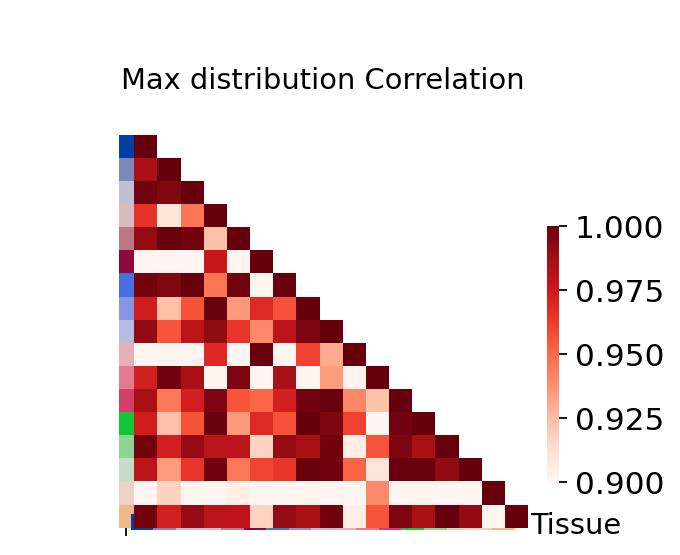

In [103]:
import seaborn as sns
import matplotlib.pyplot as plt
mask = np.array(human_max_pd)
mask[np.tril_indices_from(mask)] = False #下三角
g=sns.clustermap(human_max_pd,cmap='Reds',mask=mask,yticklabels=True,xticklabels=True,
           square=True,annot=False,vmax=1, vmin=0.9,col_cluster=False,row_cluster=False,
                 row_colors=data_df,col_colors=data_df
              )
g.fig.set_size_inches(4, 4)
g.ax_col_colors.set_position([0.20, 0.175, 0.6, 0.025]) 
g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_yticks([])
g.cax.set_position([0.85, 0.25, 0.02, 0.4])  # Adjust the position as needed
g.ax_row_colors.xaxis.set_ticklabels([])
labels=g.ax_col_colors.yaxis.get_ticklabels()
plt.setp(labels, horizontalalignment='left',fontsize=13)
g.fig.suptitle('Max distribution Correlation',x=0.5,y=0.9,fontsize=13)
#plt.savefig("figures/fig_max_cor.png",dpi=300,bbox_inches = 'tight')
#plt.savefig("pdf/fig_max_cor.pdf",dpi=300,bbox_inches = 'tight')

In [54]:
from scipy import stats
human_median_pd=pd.DataFrame(index=human_median.keys())
for i in human_median.keys():
    human_median_test=[]
    mu_i=np.mean(human_median[i])
    sigma_i=np.std(human_median[i])
    count_i,bins_i=np.histogram(human_median[i],bins=100)
    y_i=stats.norm.pdf(bins_i, mu_i, sigma_i)
    for j in human_median.keys():
        mu_j=np.mean(human_median[j])
        sigma_j=np.std(human_median[j])
        count_j,bins_j=np.histogram(human_median[j],bins=100)
        y_j=stats.norm.pdf(bins_j, mu_j, sigma_j)
        human_median_test.append(stats.spearmanr(y_i,y_j)[0])
    human_median_pd[i]=human_median_test
human_median_pd.head()

,Liver,Colon,Trachea,Thymus,Brain_Neurons,Bladder,Marrow,Pancreas,Muscle,Tongue,Fat,Mammary,Kidney,Brain_Microglia,Spleen,Heart,Lung
Liver,1.000000,0.999872,0.999988,1.000000,0.999988,0.999627,0.999988,0.999988,1.000000,0.999441,0.999988,0.999942,0.999988,1.000000,1.000000,0.999988,0.999988
Colon,0.999872,1.000000,0.999918,0.999872,0.999849,0.999872,0.999918,0.999918,0.999872,0.999709,0.999849,0.999977,0.999849,0.999872,0.999872,0.999849,0.999849
Trachea,0.999988,0.999918,1.000000,0.999988,0.999965,0.999674,1.000000,1.000000,0.999988,0.999487,0.999965,0.999977,0.999965,0.999988,0.999988,0.999965,0.999965
Thymus,1.000000,0.999872,0.999988,1.000000,0.999988,0.999627,0.999988,0.999988,1.000000,0.999441,0.999988,0.999942,0.999988,1.000000,1.000000,0.999988,0.999988
Brain_Neurons,0.999988,0.999849,0.999965,0.999988,1.000000,0.999604,0.999965,0.999965,0.999988,0.999418,1.000000,0.999918,1.000000,0.999988,0.999988,1.000000,1.000000


Text(0.5, 0.9, 'Median distribution Correlation')

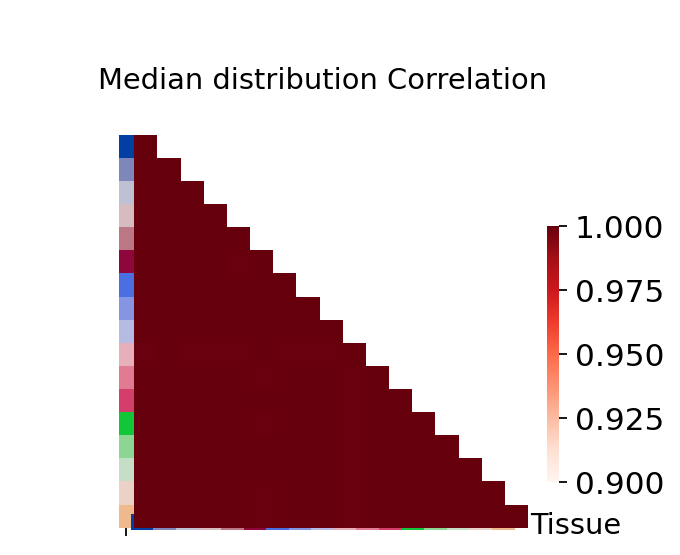

In [55]:
g=sns.clustermap(human_median_pd,cmap='Reds',mask=mask,yticklabels=True,xticklabels=True,
           square=True,annot=False,vmax=1, vmin=0.9,col_cluster=False,row_cluster=False,
                 row_colors=data_df,col_colors=data_df
              )
g.fig.set_size_inches(4, 4)
g.ax_col_colors.set_position([0.20, 0.175, 0.6, 0.025]) 
g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_yticks([])
g.cax.set_position([0.85, 0.25, 0.02, 0.4])  # Adjust the position as needed
g.ax_row_colors.xaxis.set_ticklabels([])
labels=g.ax_col_colors.yaxis.get_ticklabels()
plt.setp(labels, horizontalalignment='left',fontsize=13)
g.fig.suptitle('Median distribution Correlation',x=0.5,y=0.9,fontsize=13)
#plt.savefig("figures/fig_median_cor.png",dpi=300,bbox_inches = 'tight')
#plt.savefig("pdf/fig_median_cor.pdf",dpi=300,bbox_inches = 'tight')

In [56]:
from scipy import stats
human_mean_pd=pd.DataFrame(index=human_mean.keys())
for i in human_mean.keys():
    human_mean_test=[]
    mu_i=np.mean(human_mean[i])
    sigma_i=np.std(human_mean[i])
    count_i,bins_i=np.histogram(human_mean[i],bins=100)
    y_i=stats.norm.pdf(bins_i, mu_i, sigma_i)
    for j in human_mean.keys():
        mu_j=np.mean(human_mean[j])
        sigma_j=np.std(human_mean[j])
        count_j,bins_j=np.histogram(human_mean[j],bins=100)
        y_j=stats.norm.pdf(bins_j, mu_j, sigma_j)
        human_mean_test.append(stats.spearmanr(y_i,y_j)[0])
    human_mean_pd[i]=human_mean_test
human_mean_pd.head()

,Liver,Colon,Trachea,Thymus,Brain_Neurons,Bladder,Marrow,Pancreas,Muscle,Tongue,Fat,Mammary,Kidney,Brain_Microglia,Spleen,Heart,Lung
Liver,1.000000,0.999453,0.999942,0.999604,0.999394,0.997006,0.999022,0.999942,0.999802,0.997006,1.000000,0.999022,0.999394,0.999604,0.999802,0.999394,1.000000
Colon,0.999453,1.000000,0.999732,0.998427,0.998148,0.998742,0.999918,0.999732,0.998765,0.998742,0.999453,0.999918,0.998148,0.998427,0.998765,0.998148,0.999453
Trachea,0.999942,0.999732,1.000000,0.999301,0.999056,0.997589,0.999394,1.000000,0.999557,0.997589,0.999942,0.999394,0.999056,0.999301,0.999557,0.999056,0.999942
Thymus,0.999604,0.998427,0.999301,1.000000,0.999965,0.995620,0.997857,0.999301,0.999953,0.995620,0.999604,0.997857,0.999965,1.000000,0.999953,0.999965,0.999604
Brain_Neurons,0.999394,0.998148,0.999056,0.999965,1.000000,0.995341,0.997577,0.999056,0.999849,0.995341,0.999394,0.997577,1.000000,0.999965,0.999849,1.000000,0.999394


Text(0.5, 0.9, 'Mean distribution Correlation')

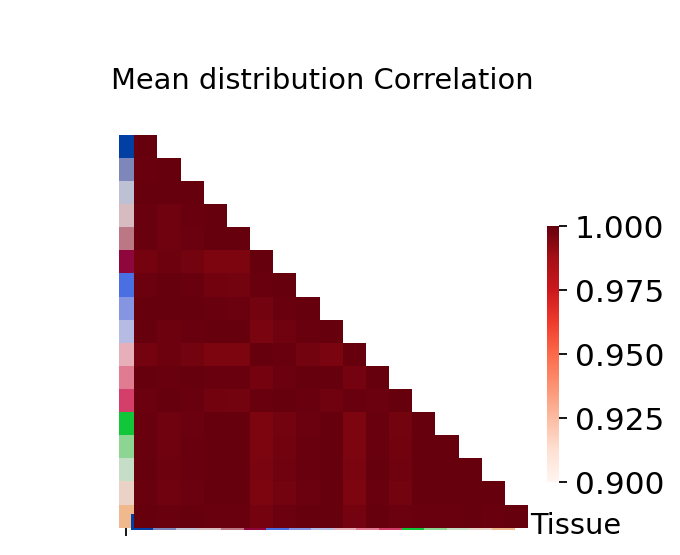

In [57]:
g=sns.clustermap(human_mean_pd,cmap='Reds',mask=mask,yticklabels=True,xticklabels=True,
           square=True,annot=False,vmax=1, vmin=0.9,col_cluster=False,row_cluster=False,
                 row_colors=data_df,col_colors=data_df
              )
g.fig.set_size_inches(4, 4)
g.ax_col_colors.set_position([0.20, 0.175, 0.6, 0.025]) 
g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_yticks([])
g.cax.set_position([0.85, 0.25, 0.02, 0.4])  # Adjust the position as needed
g.ax_row_colors.xaxis.set_ticklabels([])
labels=g.ax_col_colors.yaxis.get_ticklabels()
plt.setp(labels, horizontalalignment='left',fontsize=13)
g.fig.suptitle('Mean distribution Correlation',x=0.5,y=0.9,fontsize=13)
#plt.savefig("figures/fig_mean_cor.png",dpi=300,bbox_inches = 'tight')
#plt.savefig("pdf/fig_mean_cor.pdf",dpi=300,bbox_inches = 'tight')

In [58]:
from scipy import stats
human_std_pd=pd.DataFrame(index=human_std.keys())
for i in human_std.keys():
    human_std_test=[]
    mu_i=np.mean(human_std[i])
    sigma_i=np.std(human_std[i])
    count_i,bins_i=np.histogram(human_std[i],bins=100)
    y_i=stats.norm.pdf(bins_i, mu_i, sigma_i)
    for j in human_std.keys():
        mu_j=np.mean(human_std[j])
        sigma_j=np.std(human_std[j])
        count_j,bins_j=np.histogram(human_std[j],bins=100)
        y_j=stats.norm.pdf(bins_j, mu_j, sigma_j)
        human_std_test.append(stats.spearmanr(y_i,y_j)[0])
    human_std_pd[i]=human_std_test
human_std_pd.head()

,Liver,Colon,Trachea,Thymus,Brain_Neurons,Bladder,Marrow,Pancreas,Muscle,Tongue,Fat,Mammary,Kidney,Brain_Microglia,Spleen,Heart,Lung
Liver,1.000000,0.999033,0.999755,0.997880,0.973582,0.999744,0.998987,0.989586,0.996319,0.990879,0.997880,0.999033,0.962656,0.974665,0.999033,0.996319,1.000000
Colon,0.999033,1.000000,0.999755,0.999767,0.981654,0.997822,0.996133,0.994688,0.999080,0.984531,0.999767,1.000000,0.971951,0.965195,1.000000,0.999080,0.999033
Trachea,0.999755,0.999755,1.000000,0.999056,0.977798,0.999010,0.997775,0.992347,0.997927,0.987874,0.999056,0.999755,0.967467,0.970052,0.999755,0.997927,0.999755
Thymus,0.997880,0.999767,0.999056,1.000000,0.985137,0.996226,0.994106,0.996599,0.999767,0.980897,1.000000,0.999767,0.976098,0.960140,0.999767,0.999767,0.997880
Brain_Neurons,0.973582,0.981654,0.977798,0.985137,1.000000,0.968992,0.964042,0.995411,0.988259,0.940559,0.985137,0.981654,0.998509,0.911206,0.981654,0.988259,0.973582


Text(0.5, 0.9, 'Std distribution Correlation')

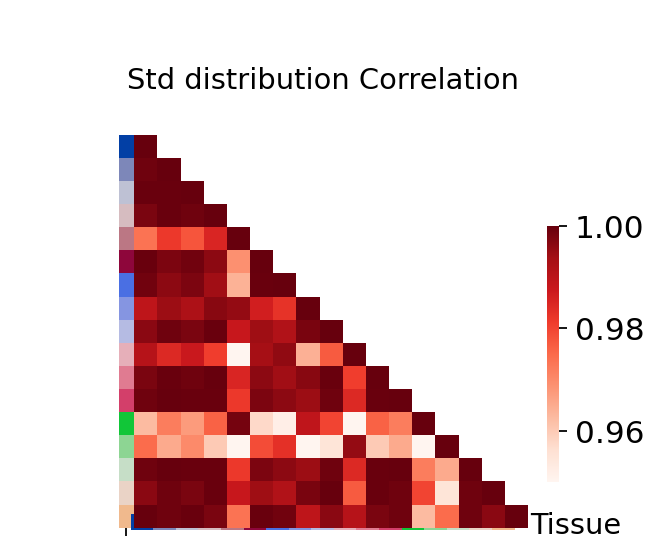

In [59]:
g=sns.clustermap(human_std_pd,cmap='Reds',mask=mask,yticklabels=True,xticklabels=True,
           square=True,annot=False,vmax=1, vmin=0.95,col_cluster=False,row_cluster=False,
                 row_colors=data_df,col_colors=data_df
              )
g.fig.set_size_inches(4, 4)
g.ax_col_colors.set_position([0.20, 0.175, 0.6, 0.025]) 
g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_yticks([])
g.cax.set_position([0.85, 0.25, 0.02, 0.4])  # Adjust the position as needed
g.ax_row_colors.xaxis.set_ticklabels([])
labels=g.ax_col_colors.yaxis.get_ticklabels()
plt.setp(labels, horizontalalignment='left',fontsize=13)
g.fig.suptitle('Std distribution Correlation',x=0.5,y=0.9,fontsize=13)
#plt.savefig("figures/fig_std_cor.png",dpi=300,bbox_inches = 'tight')
#plt.savefig("pdf/fig_std_cor.pdf",dpi=300,bbox_inches = 'tight')

(array([ 0.,  5., 10., 15.]),
 [Text(0.0, 0, '0'),
  Text(5.0, 0, '5'),
  Text(10.0, 0, '10'),
  Text(15.0, 0, '15')])

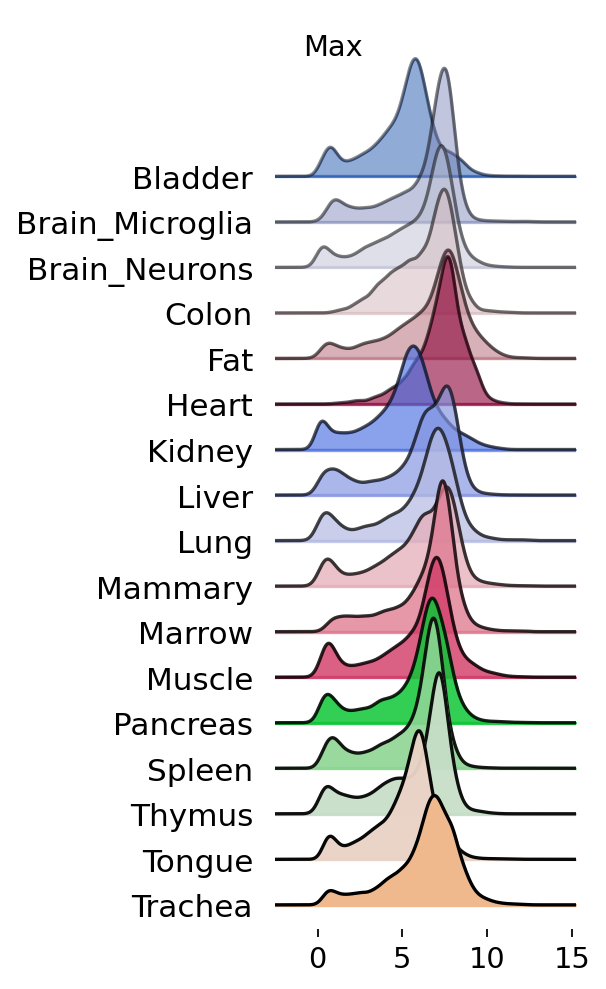

In [62]:
import joypy
df=pd.DataFrame(columns=['x','g'])
k=0
for i in human_max.keys():
  df1=pd.DataFrame()
  df1['x']=human_max[i]
  df1['g']=[j for j in [i.replace('TS_','')]*len(df1)]
  df1['x1']=[j for j in [k]*len(df1)]
  df1['x']=df1['x']+df1['x1']
  del df1['x1']
  df=pd.concat([df,df1])
  k+=0
corr_feature = ['x','g']
corr_df = df[corr_feature]
fig, axes = joypy.joyplot(corr_df,column = 'x', by='g', figsize=(4,6.5),
                          fill=True, fade=True,color=sc.pl.palettes.zeileis_28)
plt.suptitle('Max',fontsize=13,y=0.95,horizontalalignment='left') 
plt.xticks(fontsize=13)

In [66]:
corr_df.loc[corr_df['g']=='Liver','x'].values

array([6.7472291 , 4.67000103, 5.06822205, ..., 5.78964281, 8.33014393,
       6.9180274 ])

In [68]:
import numpy as np
import scipy.stats
p=corr_df.loc[corr_df['g']=='Liver','x'].values
q=corr_df.loc[corr_df['g']=='Tongue','x'].values
def KL_divergence(p,q):
    return scipy.stats.entropy(p, q)
print(KL_divergence(p,q)) # 0.011735745199107783
print(KL_divergence(q,p)) # 0.013183150978050884

def JS_divergence(p,q):
    M=(p+q)/2
    return 0.5*scipy.stats.entropy(p, M)+0.5*scipy.stats.entropy(q, M)

print(JS_divergence(p,q))  # 0.003093977084273652
print(JS_divergence(q,p)) # 0.24719159952098618
print(JS_divergence(p,p)) # 0.0

0.2011590318764863
0.24347321410874367


(array([0. , 0.5, 1. , 1.5]),
 [Text(0.0, 0, '0.0'),
  Text(0.5, 0, '0.5'),
  Text(1.0, 0, '1.0'),
  Text(1.5, 0, '1.5')])

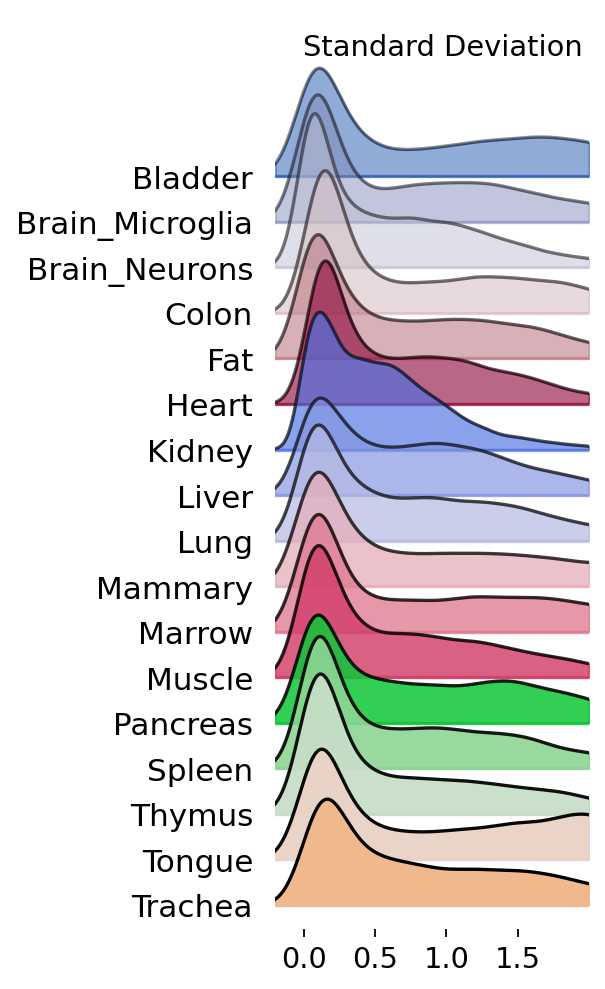

In [76]:
df=pd.DataFrame(columns=['x','g'])
k=0
for i in human_std.keys():
  df1=pd.DataFrame()
  df1['x']=human_std[i]
  df1['g']=[j for j in [i.replace('TS_','')]*len(df1)]
  df1['x1']=[j for j in [k]*len(df1)]
  df1['x']=df1['x']+df1['x1']
  del df1['x1']
  df=pd.concat([df,df1])
  k+=0

import joypy
corr_feature = ['x','g']
corr_df = df[corr_feature]
fig, axes = joypy.joyplot(corr_df,column = 'x', by='g', figsize=(4,6.5),x_range=[-0.2,2],
                          fill=True, fade=True,color=sc.pl.palettes.zeileis_28)
plt.suptitle('Standard Deviation',fontsize=13,y=0.95,horizontalalignment='left') 
plt.xticks(fontsize=13)

In [77]:
import numpy as np
import scipy.stats
p=corr_df.loc[corr_df['g']=='Liver','x'].values
q=corr_df.loc[corr_df['g']=='Tongue','x'].values
def KL_divergence(p,q):
    return scipy.stats.entropy(p, q)
print(KL_divergence(p,q)) # 0.011735745199107783
print(KL_divergence(q,p)) # 0.013183150978050884

def JS_divergence(p,q):
    M=(p+q)/2
    return 0.5*scipy.stats.entropy(p, M)+0.5*scipy.stats.entropy(q, M)

print(JS_divergence(p,q))  # 0.003093977084273652
print(JS_divergence(q,p)) # 0.24719159952098618
print(JS_divergence(p,p)) # 0.0

0.9205870891097677
0.905076226978768
0.17331222000262492
0.17331222000262492
0.0


(array([0. , 0.5, 1. ]),
 [Text(0.0, 0, '0.0'), Text(0.5, 0, '0.5'), Text(1.0, 0, '1.0')])

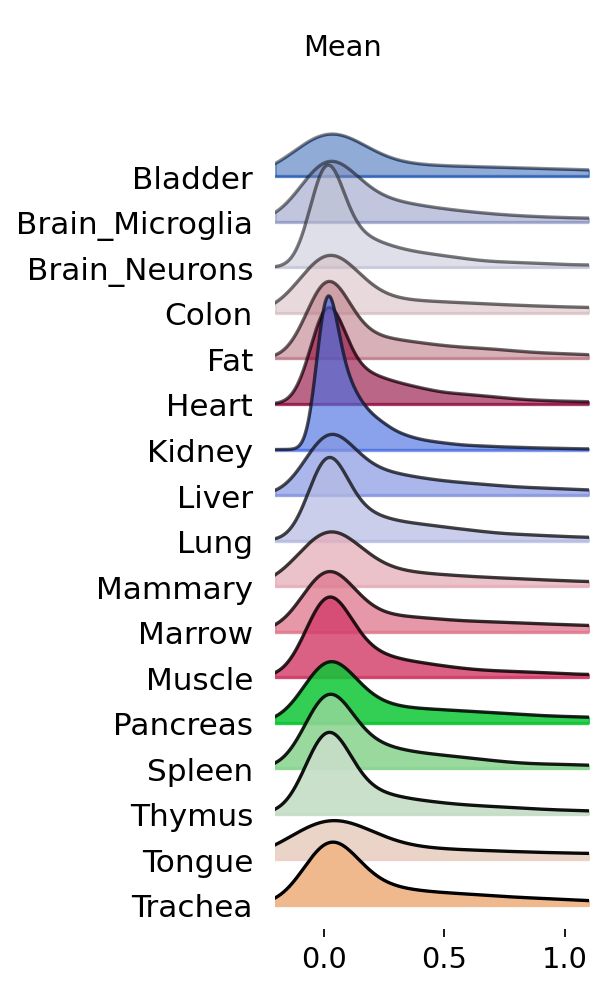

In [72]:
df=pd.DataFrame(columns=['x','g'])
k=0
for i in human_mean.keys():
  df1=pd.DataFrame()
  df1['x']=human_mean[i]
  df1['g']=[j for j in [i.replace('TS_','')]*len(df1)]
  df1['x1']=[j for j in [k]*len(df1)]
  df1['x']=df1['x']+df1['x1']
  del df1['x1']
  df=pd.concat([df,df1])
  k+=0

import joypy
corr_feature = ['x','g']
corr_df = df[corr_feature]
fig, axes = joypy.joyplot(corr_df,column = 'x', by='g', figsize=(4,6.5),x_range=[-0.2,1.1],
                          fill=True, fade=True,color=sc.pl.palettes.zeileis_28)
plt.suptitle('Mean',fontsize=13,y=0.95,horizontalalignment='left') 
plt.xticks(fontsize=13)

In [73]:
import numpy as np
import scipy.stats
p=corr_df.loc[corr_df['g']=='Liver','x'].values
q=corr_df.loc[corr_df['g']=='Tongue','x'].values
def KL_divergence(p,q):
    return scipy.stats.entropy(p, q)
print(KL_divergence(p,q)) # 0.011735745199107783
print(KL_divergence(q,p)) # 0.013183150978050884

def JS_divergence(p,q):
    M=(p+q)/2
    return 0.5*scipy.stats.entropy(p, M)+0.5*scipy.stats.entropy(q, M)

print(JS_divergence(p,q))  # 0.003093977084273652
print(JS_divergence(q,p)) # 0.24719159952098618
print(JS_divergence(p,p)) # 0.0

2.572868045211641
2.3337636364274212
0.35950477889216004
0.35950477889216004
0.0


Text(0.5, 0.95, 'Median')

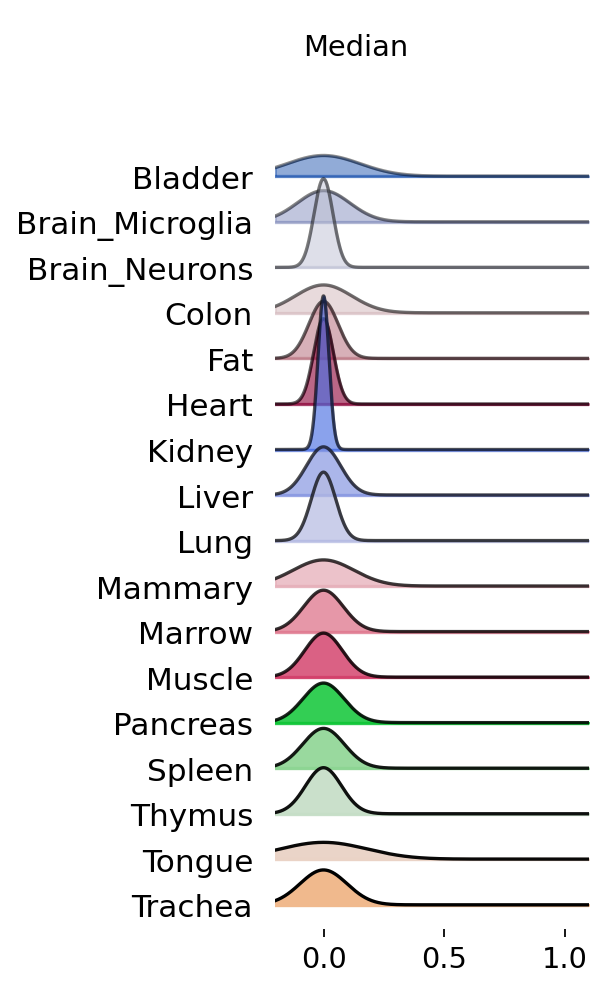

In [74]:
df=pd.DataFrame(columns=['x','g'])
k=0
for i in human_median.keys():
  df1=pd.DataFrame()
  df1['x']=human_median[i]
  df1['g']=[j for j in [i.replace('TS_','')]*len(df1)]
  df1['x1']=[j for j in [k]*len(df1)]
  df1['x']=df1['x']+df1['x1']
  del df1['x1']
  df=pd.concat([df,df1])
  k+=0

import joypy
corr_feature = ['x','g']
corr_df = df[corr_feature]
fig, axes = joypy.joyplot(corr_df,column = 'x', by='g', figsize=(4,6.5),x_range=[-0.2,1.1],
                          fill=True, fade=True,color=sc.pl.palettes.zeileis_28)
plt.xticks(fontsize=13)
#plt.yticks(fontsize=12)
plt.suptitle('Median',fontsize=13,y=0.95,horizontalalignment='left') 

In [75]:
import numpy as np
import scipy.stats
p=corr_df.loc[corr_df['g']=='Liver','x'].values
q=corr_df.loc[corr_df['g']=='Tongue','x'].values
def KL_divergence(p,q):
    return scipy.stats.entropy(p, q)
print(KL_divergence(p,q)) # 0.011735745199107783
print(KL_divergence(q,p)) # 0.013183150978050884

def JS_divergence(p,q):
    M=(p+q)/2
    return 0.5*scipy.stats.entropy(p, M)+0.5*scipy.stats.entropy(q, M)

print(JS_divergence(p,q))  # 0.003093977084273652
print(JS_divergence(q,p)) # 0.24719159952098618
print(JS_divergence(p,p)) # 0.0

inf
inf
1.0834943562944592
1.0834943562944592
0.0


(array([0., 1.]), [Text(0.0, 0, '0'), Text(1.0, 0, '1')])

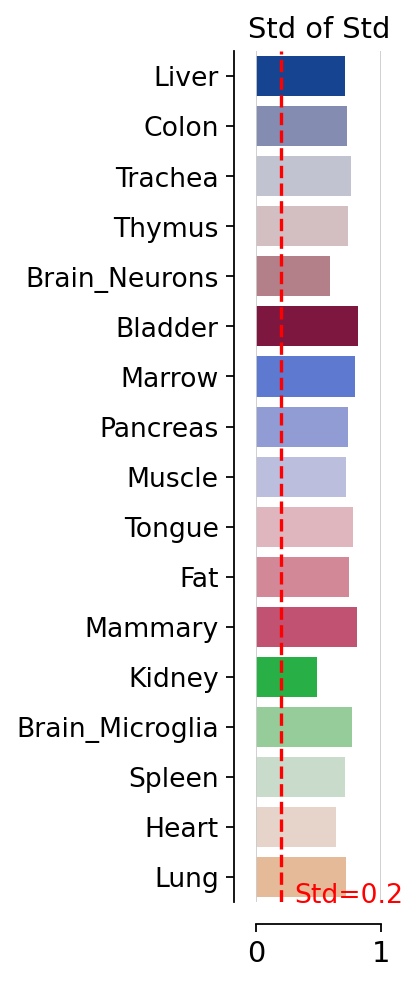

In [43]:
#定义图片大小
pp=plt.figure(figsize=(1,7))
#用ax控制图片
ax=pp.add_subplot(1,1,1)
x = [i.replace('TS_','') for i in list(human_std.keys())]
y1=[]
for i in human_std.keys():
    y1.append(np.std(human_std[i]))
sns.barplot(x=y1, y=x,ax=ax,palette=sc.pl.palettes.zeileis_28)
# 设置左边和下边的坐标轴线为独立的线段
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
plt.xlim(0,1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

ax.axvline(x=0.2, color='r', linestyle='--')
ax.text(0.3,len(human_std.keys())-0.5,'Std=0.2',fontsize=12,color='r')


plt.title('Std of Std',fontsize=13)
plt.yticks(fontsize=12)
plt.xticks(fontsize=13)

(array([0. , 0.5]), [Text(0.0, 0, '0.0'), Text(0.5, 0, '0.5')])

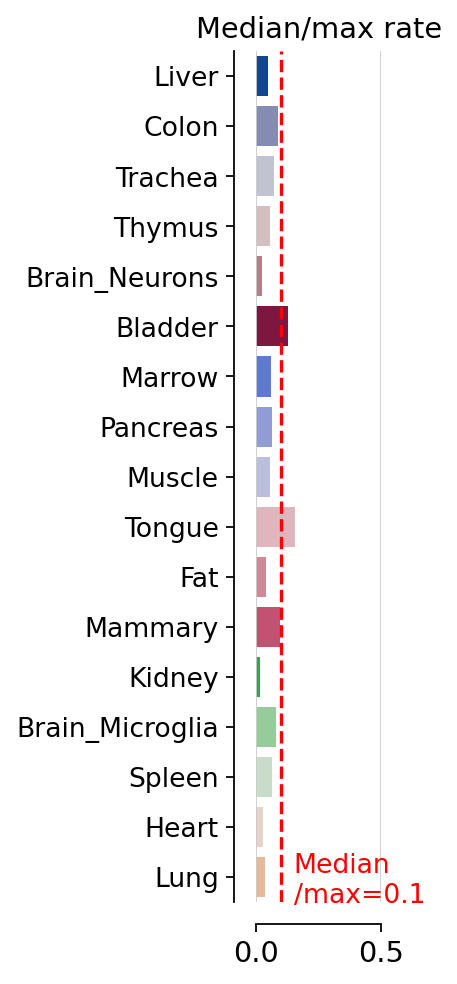

In [44]:
#定义图片大小
pp=plt.figure(figsize=(1,7))
#用ax控制图片
ax=pp.add_subplot(1,1,1)
x = [i.replace('TS_','') for i in list(human_std.keys())]
y1=[]
for i in human_median.keys():
    y1.append(np.std(np.array(human_median[i])/np.array(human_max[i])))
sns.barplot(x=y1, y=x,ax=ax,palette=sc.pl.palettes.zeileis_28)
# 设置左边和下边的坐标轴线为独立的线段
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
plt.xlim(0,0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

ax.axvline(x=0.1, color='r', linestyle='--')
ax.text(0.15,len(human_std.keys())-0.5,'Median\n/max=0.1',fontsize=12,color='r')


plt.title('Median/max rate',fontsize=13)
plt.yticks(fontsize=12)
plt.xticks(fontsize=13)

In [78]:
import numpy as np
import scipy.stats
p=corr_df.loc[corr_df['g']=='Liver','x'].values
q=corr_df.loc[corr_df['g']=='Tongue','x'].values
def KL_divergence(p,q):
    return scipy.stats.entropy(p, q)
print(KL_divergence(p,q)) # 0.011735745199107783
print(KL_divergence(q,p)) # 0.013183150978050884

def JS_divergence(p,q):
    M=(p+q)/2
    return 0.5*scipy.stats.entropy(p, M)+0.5*scipy.stats.entropy(q, M)

print(JS_divergence(p,q))  # 0.003093977084273652
print(JS_divergence(q,p)) # 0.24719159952098618


0.9205870891097677
0.905076226978768
0.17331222000262492
0.17331222000262492


In [ ]:
#re_dicts={}
import gc
import numpy as np
human_std={}
human_median={}
human_max={}
human_min={}
human_mean={}
eval_dict={}
for e in [100,1000,2000,5000,10000]:
    for o in organ_name:
        adata=sc.read_h5ad(f'data/mouse_h5ad/{o}_drop_raw.h5ad')
        adata.layers['counts']=adata.X.copy()
        sc.pp.normalize_total(adata)
        sc.pp.log1p(adata)
        sc.pp.highly_variable_genes(adata, n_top_genes=e, 
                                    flavor="seurat_v3",layer='counts',)
        adata=adata[:,adata.var['highly_variable']==True]


        print('...stats')
        array=adata.X.toarray()
        del adata
        gc.collect()
        human_std[o]=np.std(array,axis=0)
        human_median[o]=np.median(array,axis=0)
        human_max[o]=np.max(array,axis=0)
        human_min[o]=np.min(array,axis=0)
        human_mean[o]=np.mean(array,axis=0)
        
        
        df=pd.DataFrame(columns=['x','g'])
        k=0
        for i in human_std.keys():
            df1=pd.DataFrame()
            df1['x']=human_std[i]
            df1['g']=[j for j in [i.replace('TS_','')]*len(df1)]
            df1['x1']=[j for j in [k]*len(df1)]
            df1['x']=df1['x']+df1['x1']
            del df1['x1']
            df=pd.concat([df,df1])
            k+=0

        import joypy
        corr_feature = ['x','g']
        corr_df = df[corr_feature]
        eval_dict[e]=corr_df

        #adata.__delete__()

        del array


In [81]:
eval_dict[100]

,x,g
0,1.182901,Liver
1,2.295066,Liver
2,2.016364,Liver
3,2.404137,Liver
4,2.137916,Liver
...,...,...
95,0.727631,Lung
96,1.446455,Lung
97,1.481830,Lung
98,1.909384,Lung


In [88]:
js_pd_dict={}
for e in [100,1000,2000,5000,10000]:
    js_pd=pd.DataFrame(index=organ_name,columns=organ_name)
    corr_df=eval_dict[e]
    for o1 in organ_name:
        for o2 in organ_name:
            p=corr_df.loc[corr_df['g']==o1,'x'].values
            q=corr_df.loc[corr_df['g']==o2,'x'].values
            js_pd.loc[o1,o2]=JS_divergence(p,q)
    js_pd_dict[e]=js_pd

In [109]:
for e in [100,1000,2000,5000,10000]:
    for o1 in organ_name:
        js_pd_dict[e][o1]=js_pd_dict[e][o1].astype(float)

In [132]:
for e in [100,1000,2000,5000,10000]:
    print(js_pd_dict[e].mean().mean())

0.04841918412256332
0.07841589251364801
0.09005899002018411
0.11316115872491027
0.17991579533832544


In [145]:
kl_pd_dict={}
for e in [100,1000,2000,5000,10000]:
    kl_pd=pd.DataFrame(index=organ_name,columns=organ_name)
    corr_df=eval_dict[e]
    for o1 in organ_name:
        for o2 in organ_name:
            p=corr_df.loc[corr_df['g']==o1,'x'].values
            q=corr_df.loc[corr_df['g']==o2,'x'].values
            kl_pd.loc[o1,o2]=KL_divergence(p,q)
    kl_pd_dict[e]=kl_pd

In [160]:
kl_pd_dict={}
for e in [100,1000,2000,5000,10000]:
    kl_pd=pd.DataFrame(index=organ_name,columns=organ_name)
    corr_df=eval_dict[e]
    for o1 in organ_name:
        for o2 in organ_name:
            p=corr_df.loc[corr_df['g']==o1,'x'].values
            q=corr_df.loc[corr_df['g']==o2,'x'].values
            kl_pd.loc[o1,o2]=scipy.stats.ks_2samp(p, q, 
                                                   alternative='two-sided', mode='auto')[0]
    kl_pd_dict[e]=kl_pd

In [161]:
for e in [100,1000,2000,5000,10000]:
    for o1 in organ_name:
        kl_pd_dict[e][o1]=kl_pd_dict[e][o1].astype(float)

In [162]:
for e in [100,1000,2000,5000,10000]:
    print(kl_pd_dict[e].mean().mean())

0.27432525951557096
0.18859515570934254
0.1605743944636678
0.13322629757785467
0.09929204152249134


[None, None, None]

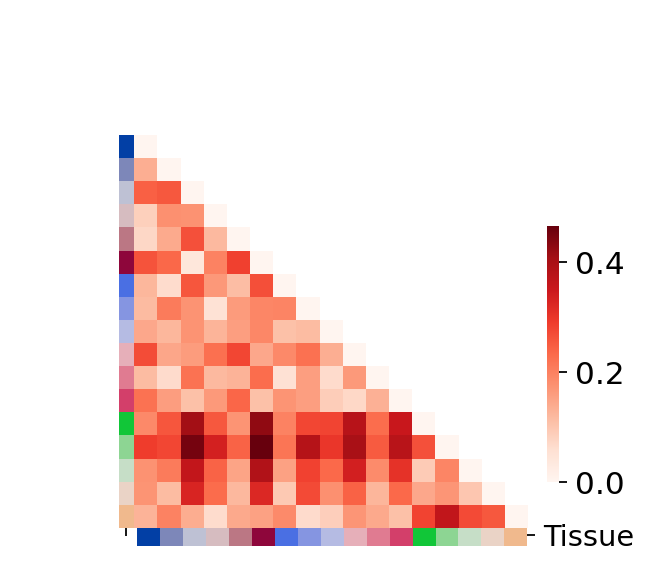

In [163]:
mask = np.array(kl_pd_dict[1000])
mask[np.tril_indices_from(mask)] = False #下三角
g=sns.clustermap(kl_pd_dict[1000],cmap='Reds',mask=mask,yticklabels=True,xticklabels=True,
           square=True,annot=False,col_cluster=False,row_cluster=False,
                 row_colors=data_df,col_colors=data_df
              )
g.fig.set_size_inches(4, 4)
g.ax_col_colors.set_position([0.21, 0.15, 0.61, 0.035]) 
g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_yticks([])
g.cax.set_position([0.85, 0.25, 0.02, 0.4])  # Adjust the position as needed
g.ax_row_colors.xaxis.set_ticklabels([])
labels=g.ax_col_colors.yaxis.get_ticklabels()
plt.setp(labels, horizontalalignment='left',fontsize=13)

(array([0., 2., 4.]),
 [Text(0.0, 0, '0'), Text(2.0, 0, '2'), Text(4.0, 0, '4')])

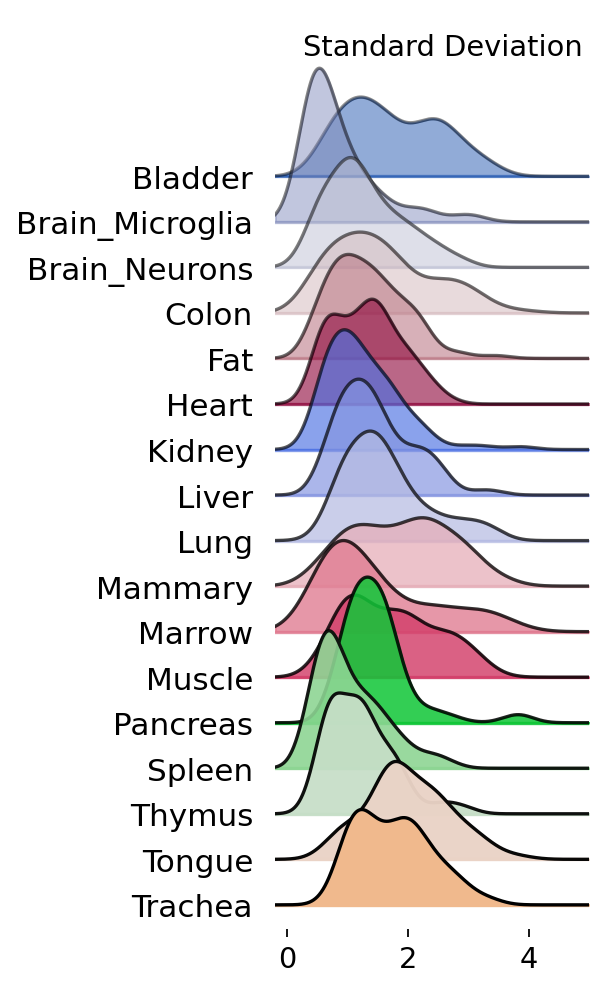

In [150]:

import joypy
corr_feature = ['x','g']
corr_df = eval_dict[100]
fig, axes = joypy.joyplot(corr_df,column = 'x', by='g', figsize=(4,6.5),x_range=[-0.2,5],
                          fill=True, fade=True,color=sc.pl.palettes.zeileis_28)
plt.suptitle('Standard Deviation',fontsize=13,y=0.95,horizontalalignment='left') 
plt.xticks(fontsize=13)

(array([0., 2., 4.]),
 [Text(0.0, 0, '0'), Text(2.0, 0, '2'), Text(4.0, 0, '4')])

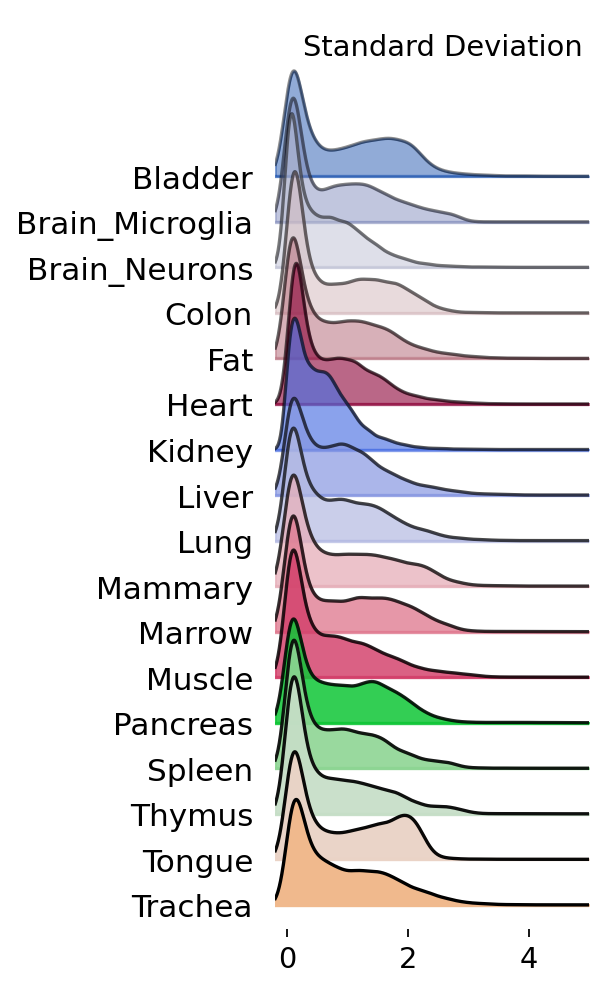

In [151]:

import joypy
corr_feature = ['x','g']
corr_df = eval_dict[10000]
fig, axes = joypy.joyplot(corr_df,column = 'x', by='g', figsize=(4,6.5),x_range=[-0.2,5],
                          fill=True, fade=True,color=sc.pl.palettes.zeileis_28)
plt.suptitle('Standard Deviation',fontsize=13,y=0.95,horizontalalignment='left') 
plt.xticks(fontsize=13)

In [4]:
import pandas as pd
df=pd.DataFrame(columns=['x','g'])
k=0
for i in human_std.keys():
    df1=pd.DataFrame()
    df1['x']=human_std[i]
    df1['g']=[j for j in [i.replace('TS_','')]*len(df1)]
    df1['x1']=[j for j in [k]*len(df1)]
    df1['x']=df1['x']+df1['x1']
    del df1['x1']
    df=pd.concat([df,df1])
    k+=0

import joypy
corr_feature = ['x','g']
corr_df = df[corr_feature]

In [2]:
from scipy import stats
import pandas as pd
human_std_pd=pd.DataFrame(index=human_std.keys())
for i in human_std.keys():
    human_std_test=[]
    mu_i=np.mean(human_std[i])
    sigma_i=np.std(human_std[i])
    count_i,bins_i=np.histogram(human_std[i],bins=100)
    y_i=stats.norm.pdf(bins_i, mu_i, sigma_i)
    for j in human_std.keys():
        mu_j=np.mean(human_std[j])
        sigma_j=np.std(human_std[j])
        count_j,bins_j=np.histogram(human_std[j],bins=100)
        y_j=stats.norm.pdf(bins_j, mu_j, sigma_j)
        human_std_test.append(stats.spearmanr(y_i,y_j)[0])
    human_std_pd[i]=human_std_test
human_std_pd.head()

NameError: name 'human_std' is not defined

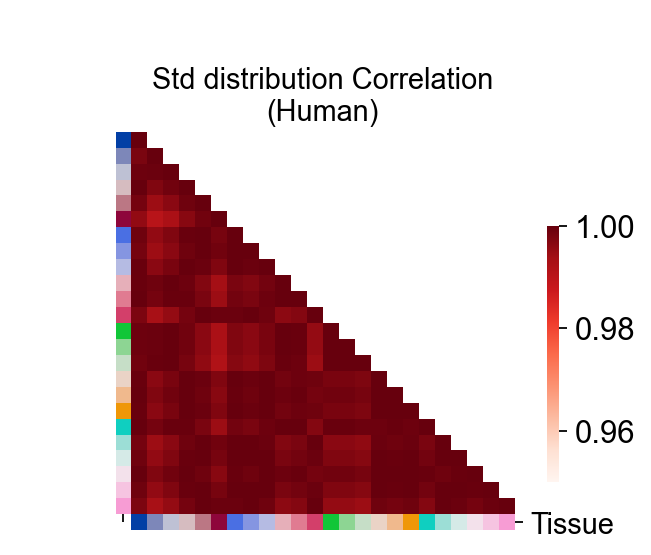

In [39]:
import scanpy as sc
data_dict=dict(zip(human_std_pd.index.tolist(),sc.pl.palettes.zeileis_28))
data_df = pd.DataFrame(data_dict.items(), columns=['index', 'Tissue'])
data_df=data_df.set_index(data_df.columns[0])

g=sns.clustermap(human_std_pd,cmap='Reds',mask=mask,yticklabels=True,xticklabels=True,
           square=True,annot=False,vmax=1, vmin=0.95,col_cluster=False,row_cluster=False,
                 row_colors=data_df,col_colors=data_df
              )
g.fig.set_size_inches(4, 4)
g.ax_col_colors.set_position([0.20, 0.175, 0.6, 0.025]) 
g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_yticks([])
g.cax.set_position([0.85, 0.25, 0.02, 0.4])  # Adjust the position as needed
g.ax_row_colors.xaxis.set_ticklabels([])
labels=g.ax_col_colors.yaxis.get_ticklabels()
plt.setp(labels, horizontalalignment='left',fontsize=13)
g.fig.suptitle('Std distribution Correlation\n(Human)',x=0.5,y=0.9,fontsize=13)
plt.savefig("figures/fig1/fig_std_cor_human.png",dpi=300,bbox_inches = 'tight')
plt.savefig("pdf/fig1/fig_std_cor_human.pdf",dpi=300,bbox_inches = 'tight')

In [8]:
import scipy.stats
organ_name=list(set(corr_df['g']))
kl_pd=pd.DataFrame(index=organ_name,columns=organ_name)
for o1 in organ_name:
    for o2 in organ_name:
        p=corr_df.loc[corr_df['g']==o1,'x'].values
        q=corr_df.loc[corr_df['g']==o2,'x'].values
        kl_pd.loc[o1,o2]=scipy.stats.ks_2samp(p, q, 
                                               alternative='two-sided', mode='auto')[0]
        
for o1 in organ_name:
    kl_pd[o1]=kl_pd[o1].astype(float)

In [43]:
kl_pd=kl_pd.loc[[i.replace('TS_','') for i in human_std_pd.index.tolist()],
         [i.replace('TS_','') for i in human_std_pd.index.tolist()]]

In [44]:
import scanpy as sc
data_dict=dict(zip(kl_pd.index.tolist(),sc.pl.palettes.zeileis_28))

In [45]:
data_df = pd.DataFrame(data_dict.items(), columns=['index', 'Tissue'])
data_df=data_df.set_index(data_df.columns[0])

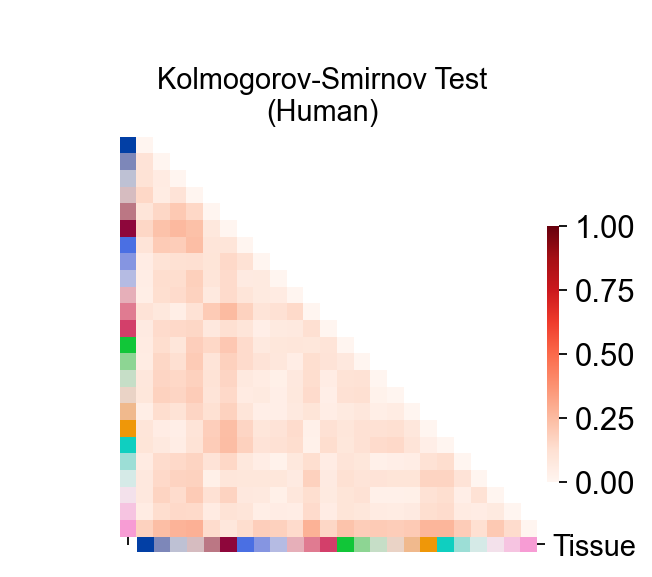

In [57]:
import seaborn as sns
mask = np.array(kl_pd)
mask[np.tril_indices_from(mask)] = False #下三角
g=sns.clustermap(kl_pd,cmap='Reds',mask=mask,yticklabels=True,xticklabels=True,
           square=True,annot=False,col_cluster=False,row_cluster=False,vmax=1,
                 row_colors=data_df,col_colors=data_df
              )
g.fig.set_size_inches(4, 4)
g.ax_col_colors.set_position([0.21, 0.14, 0.625, 0.025]) 
g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_yticks([])
g.cax.set_position([0.85, 0.25, 0.02, 0.4])  # Adjust the position as neededg.ax_row_colors.xaxis.set_ticklabels([])
labels=g.ax_col_colors.yaxis.get_ticklabels()
g.ax_row_colors.xaxis.set_ticklabels([])
plt.setp(labels, horizontalalignment='left',fontsize=13)
g.fig.suptitle('Kolmogorov-Smirnov Test\n(Human)',x=0.5,y=0.9,fontsize=13)
plt.savefig("figures/fig1/fig_ks_2samp_human.png",dpi=300,bbox_inches = 'tight')
plt.savefig("pdf/fig1/fig_ks_2samp_human.pdf",dpi=300,bbox_inches = 'tight')

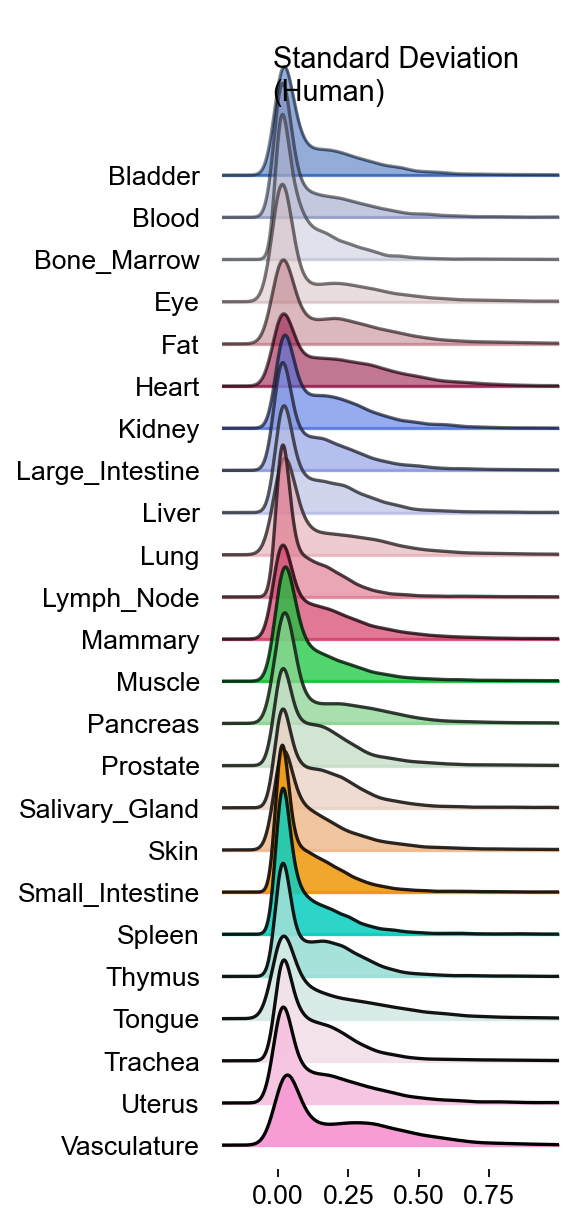

In [66]:
df=pd.DataFrame(columns=['x','g'])
k=0
for i in human_std.keys():
  df1=pd.DataFrame()
  df1['x']=human_std[i]
  df1['g']=[j for j in [i.replace('TS_','')]*len(df1)]
  df1['x1']=[j for j in [k]*len(df1)]
  df1['x']=df1['x']+df1['x1']
  del df1['x1']
  df=pd.concat([df,df1])
  k+=0

import joypy
corr_feature = ['x','g']
corr_df = df[corr_feature]
fig, axes = joypy.joyplot(corr_df,column = 'x', by='g', figsize=(4,8),x_range=[-0.2,1],
                          fill=True, fade=True,color=sc.pl.palettes.zeileis_28)
plt.suptitle('Standard Deviation\n(Human)',fontsize=13,y=0.95,horizontalalignment='left') 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
for ax in axes:
    ax.set_yticklabels(ax.get_yticklabels(),fontsize=12)

plt.savefig("figures/fig1/fig_std_distri_human.png",dpi=300,bbox_inches = 'tight')
plt.savefig("pdf/fig1/fig_std_distri_human.pdf",dpi=300,bbox_inches = 'tight')

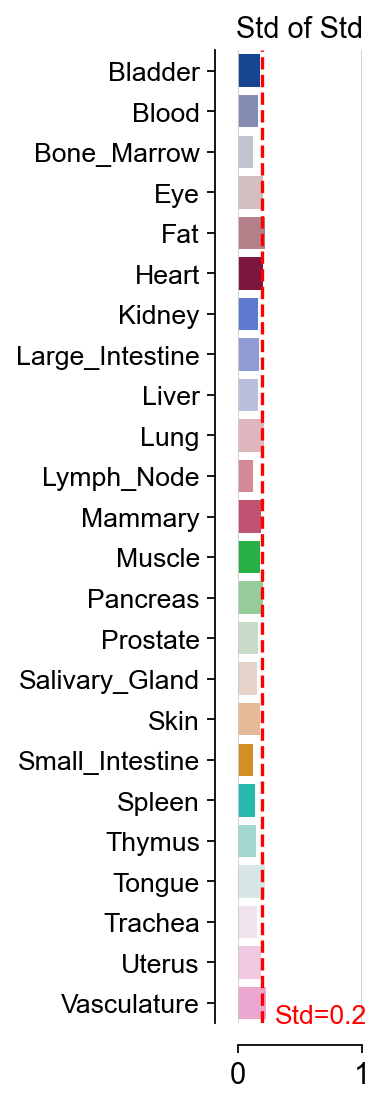

In [68]:
#定义图片大小
pp=plt.figure(figsize=(1,8))
#用ax控制图片
ax=pp.add_subplot(1,1,1)
x = [i.replace('TS_','') for i in list(human_std.keys())]
y1=[]
for i in human_std.keys():
    y1.append(np.std(human_std[i]))
sns.barplot(x=y1, y=x,ax=ax,palette=sc.pl.palettes.zeileis_28)
# 设置左边和下边的坐标轴线为独立的线段
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
plt.xlim(0,1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

ax.axvline(x=0.2, color='r', linestyle='--')
ax.text(0.3,len(human_std.keys())-0.5,'Std=0.2',fontsize=12,color='r')


plt.title('Std of Std',fontsize=13)
plt.yticks(fontsize=12)
plt.xticks(fontsize=13)

plt.savefig("figures/fig1/fig_std_std_human.png",dpi=300,bbox_inches = 'tight')
plt.savefig("pdf/fig1/fig_std_std_human.pdf",dpi=300,bbox_inches = 'tight')